In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
from torch.nn import Linear
from torch.nn.functional import dropout
from sklearn.metrics import auc


import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from torch_geometric.nn import SAGEConv, to_hetero
import torch_geometric.transforms as T
from torch_geometric.data import HeteroData

1.11.0+cu102


In [40]:
bert_movie = pd.read_csv('movie_graph/bert_100k.csv')
genres_movie = pd.read_csv('movie_graph/genres2_100k.csv')
jakard_movie = pd.read_csv('movie_graph/genres_100k.csv')
lda_movie = pd.read_csv('movie_graph/lda_100k.csv')

In [166]:
jakard_df = jakard_movie[jakard_movie['genres_sim'] >= 0.95]
m1_jakard_list = []
m2_jakard_list = []
movie_jakard_list = []
score_jakard_list = []
for row in jakard_df.values:
    m1 = int(row[0])
    m2 = int(row[1])
    score = float(row[2])
    m1_jakard_list.append(m1)
    m2_jakard_list.append(m2)
    movie_jakard_list.append([m1, m2])
    score_jakard_list.append(score)

bert_df = bert_movie[bert_movie['bert_sim'] >= 0.95]

m1_bert_list = []
m2_bert_list = []
movie_bert_list = []
score_bert_list = []
for row in bert_df.values:
    m1 = int(row[0])
    m2 = int(row[1])
    score = float(row[2])
    m1_bert_list.append(m1)
    m2_bert_list.append(m2)
    movie_bert_list.append([m1, m2])
    score_bert_list.append(score * 10)

lda_df = lda_movie[lda_movie['lda_sim'] >= 0.8]

m1_lda_list = []
m2_lda_list = []
score_lda_list = []
movie_lda_list = []
for row in lda_df.values:
    m1 = int(row[0])
    m2 = int(row[1])
    score = float(row[2])
    m1_lda_list.append(m1)
    m2_lda_list.append(m2)
    movie_lda_list.append([m1, m2])
    score_lda_list.append(score)

genre_df = genres_movie[genres_movie['genres_sim'] >= 3.5]
m1_genres_list = []
m2_genres_list = []
movie_genre_list = []
score_genre_list = []
for row in genre_df.values:
    m1 = int(row[0])
    m2 = int(row[1])
    score = float(row[2])
    m1_lda_list.append(m1)
    m2_lda_list.append(m2)
    movie_genre_list.append([m1, m2])
    score_genre_list.append(score)

In [183]:
topex = np.fromfile('ml-1m/movies.dat', sep='::')
df_topex = pd.DataFrame(data=topex)

/home/sina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  """Entry point for launching an IPython kernel.


In [191]:
# movies_df = pd.read_csv('ml-latest-small/movies.csv')
# rate_df = pd.read_csv('ml-latest-small/ratings.csv')

movies_df = pd.read_csv('ml-1m/movies.dat', sep='::')
rate_df = pd.read_csv('ml-1m/ratings.dat', sep='::')


# finding all the titles of movies genres
genres_title_list = []
for row in movies_df['genres'].values:
    genres = str(row).split('|')
    for genre in genres:
        if genre not in genres_title_list:
            genres_title_list.append(genre)
# fill genres columns
def find_genres_columns(current_genres, genres_title_list):
    temp_list = []
    for genre in genres_title_list:
        if genre in current_genres:
            temp_list.append(1)
        else:
            temp_list.append(0)
    temp_list = np.array(temp_list)
    return temp_list

def create_movie_features(movies_df):
        # find all genres and their names
    genres_title_list = []
    for row in movies_df.values:
        genres = row[2].split("|")
        for genre in genres:
            if genre not in genres_title_list:
                genres_title_list.append(genre)

    # splitting the genres of movies from their string 
    temp = movies_df.copy(deep=True)
    year_list = []
    name_list = []
    genres_list = []
    for row in temp.values:
        id = row[0]
        name = str(row[1]).strip()
        name_inx = str(name).find('(')
        year = name[-5:-1]
        try:
            year = int(year)
        except Exception as e:
            year = -1
        genres = row[2].split('|')
        genres = find_genres_columns(genres, genres_title_list)
        genres_list.append(genres)
        name = name[:name_inx-1].replace('(', '').replace(')', '')
        year_list.append(year)
        name_list.append(name)
    genres_list = np.array(genres_list)
    year_list = np.array(year_list)
    name_list = np.array(name_list)
    temp['title'] = name_list
    temp['year'] = year_list
    temp['genres'] = list(genres_list)
    for i, genre in enumerate(genres_title_list):
        temp[genre] = genres_list[:, i]
    if '(no genres listed)' in list(temp.columns):
        temp = temp[temp['(no genres listed)'] == 0]
        del temp['(no genres listed)']
    temp.head()
    movies_df = temp
    del movies_df['genres']

    # creating dictionaries for movies
    movie_dict = dict()
    movie_name_dict = dict()
    count = 0
    movies_features = []
    for row in movies_df.values:
        movie_dict[row[0]] = count
        movie_name_dict[row[1]] = row[1]
        count+=1
        movies_features.append(np.array(row[3:]))
    # movies_features =np.array(movies_features, dtype=np.int64)
    # movies_features =np.array(movies_features)
    movies_features =np.array(movies_features, dtype=np.float32)
    print(movies_features.shape)
    movies_features = torch.from_numpy(movies_features)

    return movies_features, movie_dict

# movies_features, movie_dict = find_genres_columns(movies_df, genres_title_list)
movies_features, movie_dict = create_movie_features(movies_df)

/home/sina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.
/home/sina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


(3883, 18)


In [192]:
movie_bert_list = np.array(movie_bert_list).T
score_bert_list = np.array(score_bert_list)
movie_bert_list = torch.from_numpy(movie_bert_list)
score_bert_list = torch.from_numpy(score_bert_list)

movie_lda_list = np.array(movie_lda_list).T
score_lda_list = np.array(score_lda_list)
movie_lda_list = torch.from_numpy(movie_lda_list)
score_lda_list = torch.from_numpy(score_lda_list)

movie_genre_list = np.array(movie_genre_list).T
score_genre_list = np.array(score_genre_list)
movie_genre_list = torch.from_numpy(movie_genre_list)
score_genre_list = torch.from_numpy(score_genre_list)

# movie_and_list = np.array(movie_and_list).T
# score_genre_list = np.array(score_genre_list)
# movie_and_list = torch.from_numpy(movie_and_list)
# score_genre_list = torch.from_numpy(score_genre_list)

In [193]:
user_ids = rate_df['userId'].unique()

user_dict = {}
count = 0
for id in user_ids:
    if id not in list(user_dict.keys()):
        user_dict[id] = count
        count += 1
rate_list = []
edge_list = []

for row in rate_df.values:
    user = int(row[0])
    user = user_dict[user]
    movie = int(row[1])
    if movie not in list(movie_dict.keys()):
        continue
    movie = movie_dict[movie]
    rate = int(row[2]*2)
    rate_list.append(rate)
    # if rate >= 6:
    #     rate_list.append(10)
    # else:
    #     rate_list.append(0)
    edge_list.append([user, movie])

edge_list = np.array(edge_list)
rate_list = np.array(rate_list)

edge_list = torch.from_numpy(edge_list).T
rate_list = torch.from_numpy(rate_list)

In [45]:

edge_index_list = [movie_lda_list, movie_bert_list, movie_genre_list]
edge_label_list = [score_lda_list, score_bert_list, score_genre_list]
title_list = ['lda', 'bert', 'genre']
data_list = []

for i in range(len(title_list)):
    data = HeteroData()
    data['user'].num_nodes = len(user_ids)
    data['movie'].x = movies_features
    data['user', 'rates', 'movie'].edge_index = edge_list
    data['user', 'rates', 'movie'].edge_label = rate_list
    data['movie', 'edge', 'movie'].edge_index = edge_index_list[i]
    data['movie', 'edge', 'movie'].edge_label = edge_label_list[i]
    data_list.append(data)


In [194]:
data = HeteroData()
data['user'].num_nodes = len(user_ids)
data['movie'].x = movies_features
data['user', 'rates', 'movie'].edge_index = edge_list
data['user', 'rates', 'movie'].edge_label = rate_list
# data['movie', 'edge', 'movie'].edge_index = movie_bert_list
# data['movie', 'edge', 'movie'].edge_label = score_bert_list

In [195]:
from torch_geometric.nn import GCNConv
def weighted_mse_loss(pred, target, weight=None):
    weight = 1. if weight is None else weight[target].to(pred.dtype)
    return (weight * (pred - target.to(pred.dtype)).pow(2)).mean()


class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        # self.conv2 = SAGEConv((-1, -1), hidden_channels)
        self.conv3 = SAGEConv((-1, -1), out_channels)

        # self.conv1 = GCNConv(64, 32)
        # self.conv2 = GCNConv(32, 32)

    def forward(self, x, edge_index):
        # x = self.conv1(x, edge_index).relu()
        x = self.conv1(x, edge_index).relu()
        # x = dropout(x, p=0.5, training = self.training)
        # x = self.conv2(x, edge_index).relu()
        # x = dropout(x, p=0.5, training = self.training)
        x = self.conv3(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, 2 * hidden_channels)
        self.lin2 = Linear(2 * hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = dropout(z, p=0.5, training = self.training)
        # z = self.lin1(z).relu()
        # z = dropout(z, p=0.5, training = self.training)
        z = self.lin2(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels, data):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

In [196]:
def train_test_model(train_data=None, val_data=None, test_data=None, data=None, lr = 0.01, epochs_num = 101, print_logs = True):
    model = Model(hidden_channels=64, data=data).to(device)

    with torch.no_grad():
        model.encoder(train_data.x_dict, train_data.edge_index_dict)

    weight = torch.bincount(train_data['user', 'movie'].edge_label)
    weight = weight.max() / weight

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    def train():
        model.train()
        optimizer.zero_grad()
        pred = model(train_data.x_dict, train_data.edge_index_dict,
                        train_data['user', 'movie'].edge_label_index)
        target = train_data['user', 'movie'].edge_label
        loss = weighted_mse_loss(pred, target, weight)
        loss.backward()
        optimizer.step()
        return float(loss)


    @torch.no_grad()
    def test(data):
        model.eval()
        pred = model(data.x_dict, data.edge_index_dict,
                    data['user', 'movie'].edge_label_index)
        pred = pred.clamp(min=0, max=10)
        target = data['user', 'movie'].edge_label.float()
        rmse = F.mse_loss(pred / 2, target / 2).sqrt()
        return float(rmse)

    loss_list = []
    for epoch in range(0, epochs_num):
        loss = train()
        train_rmse = test(train_data) -0.3
        val_rmse = test(val_data) -0.3
        test_rmse = test(test_data) -0.3
        loss_list.append([train_rmse, val_rmse, test_rmse])
        if epoch % 10 == 0 and print_logs == True:
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')
    loss_list = np.array(loss_list)
    return loss_list, model

def plot_losses(loss_list, min_tresh, max_tresh):
    plt.figure(figsize=(12, 10))
    plt.plot(loss_list[:, 0], label='train')
    plt.plot(loss_list[:, 1], label='val')
    plt.plot(loss_list[:, 2], label='test')
    plt.legend()
    plt.ylim(min_tresh, max_tresh)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

In [197]:
data['user'].x = torch.eye(data['user'].num_nodes, device=device)
del data['user'].num_nodes
data = T.ToUndirected()(data)
del data['movie', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.
data = data.to(device)
# Perform a link-level split into training, validation, and test edges:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')])(data)

In [198]:
loss_list, model = train_test_model(train_data, val_data, test_data, data=data, lr=0.005, epochs_num=101, print_logs=True)

RuntimeError: [enforce fail at alloc_cpu.cpp:73] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 19332083040 bytes. Error code 12 (Cannot allocate memory)

In [101]:
preds = model(test_data.x_dict, test_data.edge_index_dict,
                    test_data['user', 'movie'].edge_label_index)

In [108]:
preds = preds.detach().numpy()

In [107]:
true_label = np.array(test_data.edge_label_dict[('user', 'rates', 'movie')])

In [127]:
temp = []
for i in range(len(true_label)):
    true = true_label[i]
    pred = preds[i]
    if true > pred:
        temp.append(true-pred)
    else:
        temp.append(pred - true)


In [128]:
temp = np.array(temp)

In [129]:
temp.min()

0.0002288818359375

In [130]:
temp.max()

8.866383671760559

In [136]:
temp.argmax()

12805

In [144]:
t = list(temp.argsort()[-10:])

In [158]:
xx = np.array(test_data.edge_index_dict[('user', 'rates', 'movie')].T)[temp.argsort()[-10:]][9]

In [160]:
xx[0]

293

In [164]:
movie_dict[xx[1]]

203

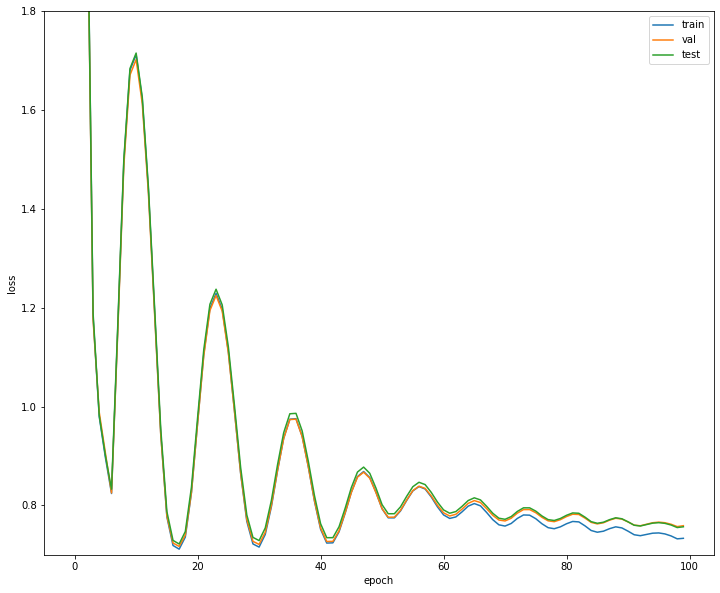

In [135]:
plot_losses(loss_list[:100], min_tresh=0.7, max_tresh=1.8)

In [28]:
result_list = []
for i, data in enumerate(data_list):
    data['user'].x = torch.eye(data['user'].num_nodes, device=device)
    del data['user'].num_nodes
    data = T.ToUndirected()(data)
    del data['movie', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.
    data = data.to(device)
    # Perform a link-level split into training, validation, and test edges:
    train_data, val_data, test_data = T.RandomLinkSplit(
        num_val=0.1,
        num_test=0.1,
        neg_sampling_ratio=0.0,
        edge_types=[('user', 'rates', 'movie')],
        rev_edge_types=[('movie', 'rev_rates', 'user')])(data)
    print(title_list[i])
    loss_list, model = train_test_model(train_data, val_data, test_data, data=data)
    result_list.append([title_list[i], loss_list])

lda
Epoch: 000, Loss: 99.8876, Train: 3.0887, Val: 3.0878, Test: 3.0714
Epoch: 010, Loss: 51.6628, Train: 2.3547, Val: 2.3546, Test: 2.3377
Epoch: 020, Loss: 26.3461, Train: 1.8332, Val: 1.8363, Test: 1.8203
Epoch: 030, Loss: 19.8993, Train: 1.2535, Val: 1.2619, Test: 1.2484
Epoch: 040, Loss: 18.7557, Train: 1.0237, Val: 1.0303, Test: 1.0241
Epoch: 050, Loss: 16.6128, Train: 1.0318, Val: 1.0370, Test: 1.0343
Epoch: 060, Loss: 15.9598, Train: 1.0617, Val: 1.0709, Test: 1.0668
Epoch: 070, Loss: 15.5515, Train: 1.0543, Val: 1.0696, Test: 1.0635
Epoch: 080, Loss: 15.1455, Train: 1.0628, Val: 1.0816, Test: 1.0744
Epoch: 090, Loss: 14.7750, Train: 1.0704, Val: 1.0918, Test: 1.0837
Epoch: 100, Loss: 14.5289, Train: 1.0588, Val: 1.0847, Test: 1.0755
bert
Epoch: 000, Loss: 104.1984, Train: 3.3586, Val: 3.3614, Test: 3.3625
Epoch: 010, Loss: 24.9071, Train: 0.9900, Val: 1.0073, Test: 1.0053
Epoch: 020, Loss: 19.5542, Train: 1.0966, Val: 1.1204, Test: 1.1159
Epoch: 030, Loss: 16.4840, Train: 1.24